In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip data.zip

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0


!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 323437, done.
remote: Counting objects: 100% (1408/1408), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 323437 (delta 1056), reused 1326 (delta 1005), pack-reused 322029
Receiving objects: 100% (323437/323437), 655.47 MiB | 23.51 MiB/s, done.
Resolving deltas: 100% (297125/297125), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import cv2
from xml.etree import ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
class Data_train(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        

        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg' or image[-4:]=='.png']
        
        
        self.classes = [_, 'champ']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

           
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0
        

        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        

        wt = img.shape[1]
        ht = img.shape[0]
        
       
        for member in root.findall('object'):
    
            labels.append(1)
            

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])


        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
files_dir = '/content/drive/MyDrive/Task/Egg/data'
dataset = Data_train(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')
img, target = dataset[78]
print(img.shape, '\n',target)


length of dataset =  306 

(224, 224, 3) 
 {'boxes': tensor([[  8.2238,  40.5333,  37.2028, 194.1333],
        [187.9720,  51.2000, 220.0839, 194.1333]]), 'labels': tensor([1, 1]), 'area': tensor([4451.1777, 4589.8599]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([78])}


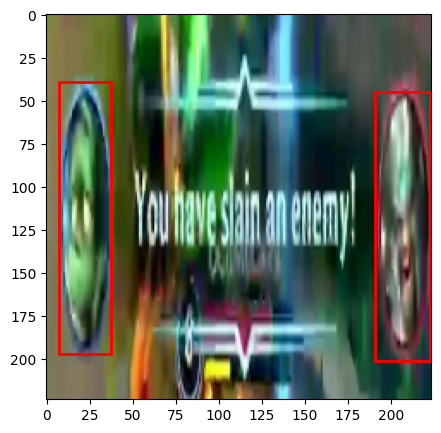

In [ ]:
def ab(x):
  return torch.tensor(x, device = 'cpu')
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = ab(box[0]), ab(box[1]), ab(box[2])-ab(box[0]), ab(box[3]-box[1])
        rect = patches.Rectangle((int(x), int(y)),
                                 int(width), int(height),
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        
        a.add_patch(rect)
    plt.show()
    
img, target = dataset[25]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = Data_train(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = Data_train(files_dir, 480, 480, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()


test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_object_detection_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 298MB/s]


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/25]  eta: 0:00:33  lr: 0.000213  loss: 0.8498 (0.8498)  loss_classifier: 0.6383 (0.6383)  loss_box_reg: 0.1647 (0.1647)  loss_objectness: 0.0204 (0.0204)  loss_rpn_box_reg: 0.0265 (0.0265)  time: 1.3512  data: 0.7453  max mem: 7676
Epoch: [0]  [10/25]  eta: 0:00:10  lr: 0.002294  loss: 0.4466 (0.5317)  loss_classifier: 0.2461 (0.3407)  loss_box_reg: 0.1444 (0.1399)  loss_objectness: 0.0203 (0.0205)  loss_rpn_box_reg: 0.0297 (0.0305)  time: 0.6737  data: 0.0898  max mem: 7834
Epoch: [0]  [20/25]  eta: 0:00:03  lr: 0.004376  loss: 0.3348 (0.4086)  loss_classifier: 0.1596 (0.2259)  loss_box_reg: 0.1304 (0.1365)  loss_objectness: 0.0158 (0.0191)  loss_rpn_box_reg: 0.0253 (0.0272)  time: 0.6066  data: 0.0246  max mem: 7834
Epoch: [0]  [24/25]  eta: 0:00:00  lr: 0.005000  loss: 0.2696 (0.3747)  loss_classifier: 0.0861 (0.1968)  loss_box_reg: 0.1277 (0.1330)  loss_objectness: 0.0158 (0.0169)  loss_rpn_box_reg: 0.0253 (0.0280)  time: 0.5901  data: 0.0221  max mem: 7834
Epoch: [

In [ ]:
model = model.to(device)
ck = torch.load('/content/drive/MyDrive/Task/Egg/model/Faster.pth')
model.load_state_dict(ck)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
len(dataset_test)

61

In [ ]:
img, target = dataset_test[60]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Task/Egg/model/Faster.pth')

MODEL OUTPUT


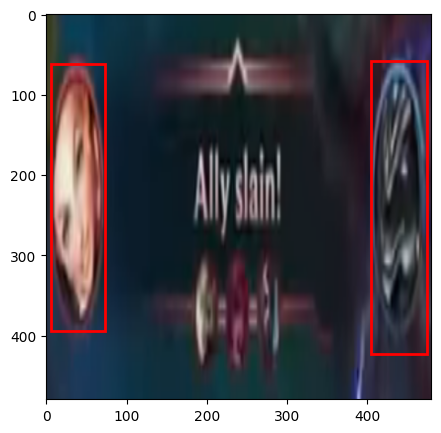

In [ ]:
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


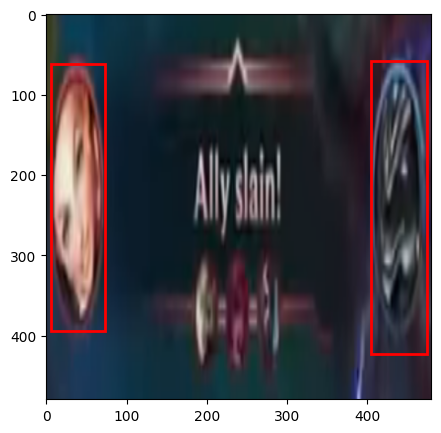

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
plot_img_bbox(torch_to_pil(img), nms_prediction)